# Sonic The Hedgehog 1 with dqn

## Step 1: Import the libraries

In [1]:
import time
import retro
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math

%matplotlib inline

In [2]:
import sys

sys.path.append('../../')
from algos.agents.dqn_agent import DQNAgent
from algos.models.dqn_cnn import DQNCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [3]:
env = retro.make(game='SonicTheHedgehog-Genesis', state='GreenHillZone.Act1', scenario='contest', record="./record_dqn")
env.seed(0)

[0, 592379725]

In [4]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## Step 3: Viewing our Enviroment

The size of frame is:  (224, 320, 3)
No. of Actions:  12


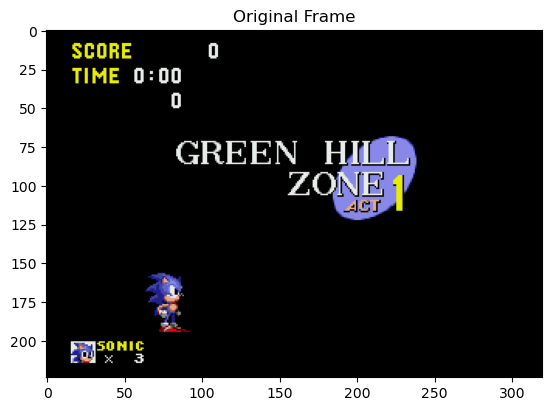

In [5]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

In [6]:
possible_actions = {
    # No Operation
    0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # Left
    1: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    # Right
    2: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    # Left, Down
    3: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
    # Right, Down
    4: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    # Down
    5: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    # Down, B
    6: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    # B
    7: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
}

### Execute the code cell below to play Sonic with a random policy.

In [7]:
env.close()

In [8]:
def random_play():
    score = 0
    env_random = retro.make(game='SonicTheHedgehog-Genesis', state='GreenHillZone.Act1', scenario='contest')
    env_random.reset()
    for i in range(2000):
        time.sleep(0.001)
        env_random.render()
        action = possible_actions[np.random.randint(len(possible_actions))]
        state, reward, done, _ = env_random.step(action)
        score += reward
        if done:
            print("Your Score at end of game is: ", score)
            break
    env_random.reset()
    env_random.render(close=True)
    env_random.close()
random_play()

In [9]:
env = retro.make(game='SonicTheHedgehog-Genesis', state='GreenHillZone.Act1', scenario='contest', record="./record_dqn")

## Step 4:Preprocessing Frame

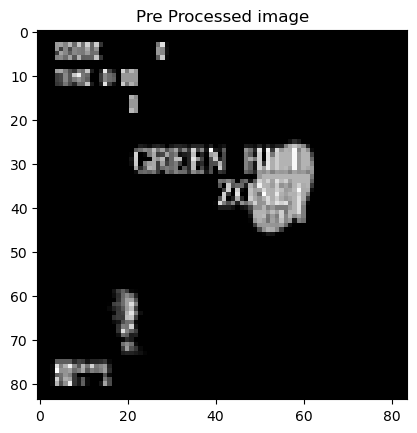

In [10]:
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (1, -1, -1, 1), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [11]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (1, -1, -1, 1), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames


## Step 6: Creating our Agent

In [12]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = len(possible_actions)
SEED = 0
GAMMA = 0.99  # discount factor
BUFFER_SIZE = 100000  # replay buffer size
BATCH_SIZE = 32  # Update batch size
LR = 0.0001  # learning rate 
TAU = 1e-3  # for soft update of target parameters
UPDATE_EVERY = 100  # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started 
EPS_START = 0.99  # starting value of epsilon
EPS_END = 0.01  # Ending value of epsilon
EPS_DECAY = 100  # Rate by which epsilon to be decayed

agent = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY,
                 UPDATE_TARGET, DQNCnn)

## Step 7: Watching untrained agent play

In [13]:
env.close()
env_untrained = retro.make(game='SonicTheHedgehog-Genesis', state='GreenHillZone.Act1', scenario='contest')

In [14]:
env_untrained.viewer = None
# watch an untrained agent
state = stack_frames(None, env_untrained.reset(), True)
for j in range(10000):
    env_untrained.render(close=False)
    action = agent.act(state, eps=0.01)
    next_state, reward, done, _ = env_untrained.step(possible_actions[action])
    state = stack_frames(state, next_state, False)
    if done:
        env_untrained.reset()
        break
env_untrained.render(close=True)
env_untrained.close()

In [15]:
env = retro.make(game='SonicTheHedgehog-Genesis', state='GreenHillZone.Act1', scenario='contest', record="./record_dqn")

## Step 8: Loading Agent
Uncomment line to load a pretrained agent

In [16]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

## Step 9: Train the Agent with DQN

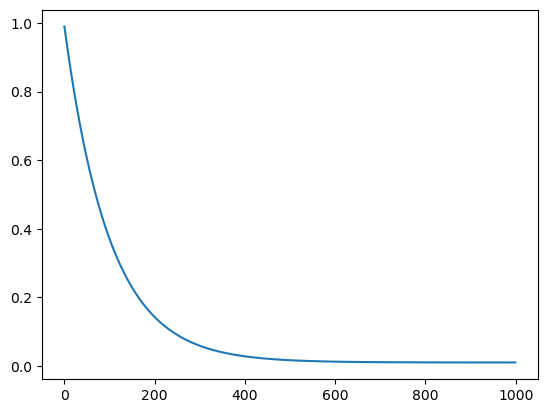

In [17]:
epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx / EPS_DECAY)

plt.plot([epsilon_by_epsiode(i) for i in range(1000)])

In [18]:
from tqdm import tqdm
def train(n_episodes=10000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    average_list = []
    for i_episode in tqdm(range(start_epoch + 1, n_episodes+1)):
        state = stack_frames(None, env.reset(), True)
        score = 0
        eps = epsilon_by_epsiode(i_episode)

        # Punish the agent for not moving forward
        prev_state = {}
        steps_stuck = 0
        timestamp = 0

        while timestamp < 4500:
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(possible_actions[action])
            score += reward

            timestamp += 1

            # Punish the agent for standing still for too long.
            if (prev_state == info):
                steps_stuck += 1
            else:
                steps_stuck = 0
            prev_state = info

            if (steps_stuck > 20):
                reward -= 1

            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score

        average_reward = np.mean(scores_window)
        average_list.append(average_reward)

        if i_episode % 100 == 0:
            torch.save(agent.policy_net.state_dict(), f'./checkpoints/dqn/policy_model/checkpoint_dqn_{i_episode}.pth')
            torch.save(agent.target_net.state_dict(), f'./checkpoints/dqn/target_model/checkpoint_dqn_{i_episode}.pth')
            np.save(f'./checkpoints/dqn/scores/scores_dqn{i_episode}.npy', np.array(scores))
            np.save(f'./checkpoints/dqn/mean_scores/scores_dqn{i_episode}.npy', np.array(average_list))


        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(scores_window), eps), end="")
    return scores, average_list


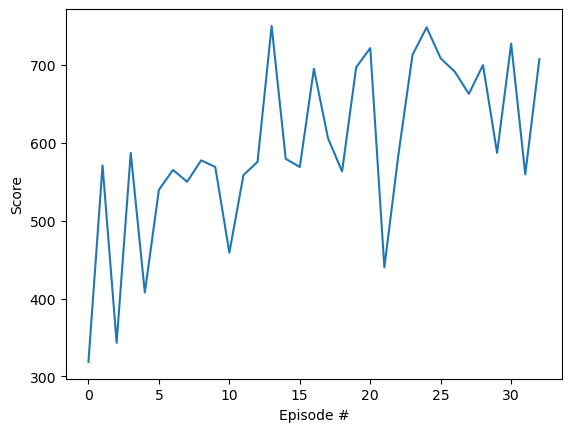

  3%|▎         | 33/1000 [15:59<12:07:56, 45.17s/it]

Episode 33	Average Score: 650.76	Epsilon: 0.71

  3%|▎         | 33/1000 [16:05<7:51:33, 29.26s/it] 


KeyboardInterrupt: 

In [15]:
av_list=[]
scores,av_list = train(10000)

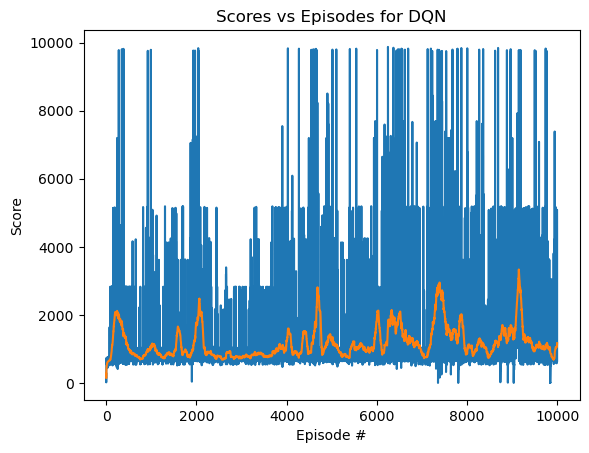

In [21]:
scores = np.load('./checkpoints/dqn/scores/scores_dqn10000.npy')
av_list = np.load('./checkpoints/dqn/mean_scores/scores_dqn10000.npy')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(av_list)), av_list)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title("Scores vs Episodes for DQN")
plt.show()

## Step 10: Watch the best movie

In [22]:
import numpy as np

# Загрузка файла
data = np.load('./checkpoints/dqn/scores/scores_dqn10000.npy')

# топ 10
top_10 = np.partition(data, -10)[-10:]
# индексы топа 10
top_10_index = np.argpartition(data, -10)[-10:]

# Создаем словарь
top_dict = {index: value for index, value in zip(top_10_index, top_10)}

# Сортируем словарь по значениям
sorted_dict = dict(sorted(top_dict.items(), key=lambda item: item[1], reverse=True))

In [23]:
sorted_dict

{6248: 9874.833328306675,
 6369: 9850.833303809166,
 8690: 9844.666642606258,
 7875: 9841.666671335697,
 2041: 9838.49995726347,
 4029: 9833.388816714287,
 8007: 9833.333329439163,
 9745: 9827.000001609325,
 7200: 9825.72221159935,
 6696: 9825.44443577528}

In [24]:
number_best = 0
list_numbers_movie = list(sorted_dict.keys())
number_movie = str(list_numbers_movie[number_best] + 6).zfill(6)
print(number_movie)

006254


In [25]:
env.close()
movie = retro.Movie(f'./record_dqn/SonicTheHedgehog-Genesis-GreenHillZone.Act1-{number_movie}.bk2')
movie.step()

env = retro.make(
    game=movie.get_game(),
    state=None,
    use_restricted_actions=retro.Actions.ALL,
    players=movie.players,
)
env.initial_state = movie.get_state()
env.reset()
env.viewer = None
state = stack_frames(None, env.reset(), True)

while movie.step():
    time.sleep(0.001)
    env.render(close=False)

    keys = []
    for p in range(movie.players):
        for i in range(env.num_buttons):
            keys.append(movie.get_key(i, p))
    next_state, reward, done, _ = env.step(keys)
    state = stack_frames(state, next_state, False)
    if done:
        env.reset()
        break
env.render(close=True)

## Step 11: Watch a Smart Agent!

In [26]:
env.close()
env = retro.make(game='SonicTheHedgehog-Genesis', state='GreenHillZone.Act1', scenario='contest')
env.seed(0)

[0, 592379725]

In [27]:
def round_to_nearest_100(n):
    if n % 100 == 0:
        return n
    else:
        return ((n // 100) + 1) * 100

In [28]:
number_best = 0
round_to_nearest_100(list_numbers_movie[number_best])

6300

In [84]:
# Загружаем веса в сети политики и цели
agent.policy_net.load_state_dict(torch.load(f'./checkpoints/dqn/policy_model/checkpoint_dqn_10000.pth'))
agent.target_net.load_state_dict(torch.load(f'./checkpoints/dqn/target_model/checkpoint_dqn_10000.pth'))

<All keys matched successfully>

In [87]:
env.viewer = None
state = stack_frames(None, env.reset(), True)
while True:
    time.sleep(0.001)
    env.render(close=False)
    action = agent.act(state, eps=0.0)
    next_state, reward, done, _ = env.step(possible_actions[action])
    state = stack_frames(state, next_state, False)
    if done:
        env.reset()
        break
env.render(close=True)